In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: Tesla V100-SXM2-32GB


In [2]:
model_tag='1.9.1.8.5_Dev_final_noQ_INP_moredim_DMR_regionsample'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch_name'
discov_key='species'
layer_key='spliced'
leaf_key='level_2'
anndata.settings.allow_write_nullable_strings = True

In [3]:
# adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/1.9.1.8.5_Dev_final_noQ_INP_moredim_regionsample/p4_adata.h5ad',backed='r')
# new_annos = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/review_annotation_2.csv',index_col=0)
# adata.obs['new_ccl'] = new_annos['new_ccl']
# adata.obs['new_neighborhood'] = new_annos['new_neighborhood']
# adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
# adata.obs['new_neighborhood_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_neighborhood'].value_counts().unstack().idxmax(1).to_dict())
# neurect_lineage = adata.obs['new_neighborhood_extended'].isin(['P','T','DMR'])|adata.obs['ccl_extended'].isin(['Astro','Oligo','Progen OPC','Ependymal','Progen Glia','Progen Astro-OPC','Progen Astro-Neuro','Hypendymal'])
# dmr_cells = adata.obs['general_region'].isin(['de','hb','mb'])
# adata.obs['DMR'] = dmr_cells
# adata.obs['DMRl2'] = adata.obs['level_2'].replace((adata.obs.groupby('level_2')['DMR'].mean()>0.5).to_dict())
# adata.obs['DMRall'] = ((adata.obs['DMRl2'].astype(bool) & adata.obs['general_region'].isin(['h'])) | adata.obs['DMR']) & neurect_lineage
# adata = adata[adata.obs['DMRall'],:].to_memory()
# adata.strings_to_categoricals()
# adata.write('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_DMR.h5ad')

In [4]:
print('saved')

saved


In [5]:
adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_DMR.h5ad'),
    mode='r', selected_keys=['S_score','G2M_score','phase','log10_n_counts','region','general_region','level_2','ccl_extended','new_neighborhood_extended', batch_key,discov_key,layer_key, 'var', 'uns'])
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')
adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
adata.obsm['phase_sex']=np.concatenate([adata.obs['S_score'].to_numpy().reshape(-1,1),adata.obs['G2M_score'].to_numpy().reshape(-1,1),adata.obs['log10_n_counts'].to_numpy().reshape(-1,1),antipode.model_functions.numpy_onehot(adata.obs['female'].cat.codes)],axis=1)
adata.obsm['phase_sex']=adata.obsm['phase_sex']/np.abs(adata.obsm['phase_sex']).max(0)#Scale so max value is magnitude 1
new_annos = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/review_annotation.csv',index_col=0,skiprows=2)
adata.obs['new_ccl'] = new_annos['new_ccl']
adata.obs['new_neighborhood'] = new_annos['new_neighborhood']
adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
adata.obs['new_neighborhood_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_neighborhood'].value_counts().unstack().idxmax(1).to_dict())

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer='spliced',normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/scratch/fast/45806/ipykernel_3834557/2015060412.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
/scratch/fast/45806/ipykernel_3834557/2015060412.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])


/scratch/fast/45806/ipykernel_3834557/2015060412.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
/scratch/fast/45806/ipykernel_3834557/2015060412.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
/scratch/fast/45806/ipykernel_3834557/2015060412.py:11: FutureWarning: The default of observed=False is depreca

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:15<00:31, 15.78s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.03s/it]

100%|██████████| 3/3 [00:37<00:00, 12.25s/it]

100%|██████████| 3/3 [00:37<00:00, 12.56s/it]

In [6]:
adata.obs['general_region_sample'] = adata.obs['general_region'].astype(str)
adata.obs.loc[adata.obs['general_region_sample']=='bn','general_region_sample'] = 'ge'
adata.obs.loc[adata.obs['general_region_sample']=='cp','general_region_sample'] = 'ge'
grs = adata.obs['general_region_sample'].unique()
grs = grs[grs!='h']
adata.obs.loc[adata.obs['general_region_sample'].isin(['h']),'general_region_sample'] = np.random.choice(grs,(adata.obs['general_region_sample'].isin(['h'])).sum())
adata.obs['general_region_sample'] = adata.obs['general_region_sample'].astype(str)
adata.obs['general_region_species'] = adata.obs['species'].astype(str) +'_'+adata.obs['general_region_sample'].astype(str)
adata.obs['general_region_species'] = adata.obs['general_region_species'].astype('category')
adata.obs.drop('general_region_sample',axis=1,inplace=True)

In [7]:
adata.obs['general_region_species'].value_counts()

general_region_species
human_hb      106079
human_de      103846
macaque_hb     67951
mouse_de       66032
mouse_hb       62257
mouse_mb       61027
macaque_de     51877
human_mb       36454
macaque_mb     26750
Name: count, dtype: int64

In [8]:
try:
    del adata.uns['hvg']
except:
    pass
try:
    del adata.uns['neighbors']
except:
    pass

In [9]:
adata

AnnData object with n_obs × n_vars = 582273 × 16738 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_DMR.h5ad'
    obs: 'G2M_score', 'S_score', 'batch_name', 'ccl_extended', 'general_region', 'level_2', 'log10_n_counts', 'new_neighborhood_extended', 'phase', 'region', 'species', 'female', 'new_ccl', 'new_neighborhood', 'general_region_species'
    var: 'highly_variable', 'highly_variable_intersection', 'highly_variable_nbatches', 'highly_variable_rank', 'mean', 'means', 'n_cells', 'std', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'general_region_color_dict', 'param_store'
    obsm: 'phase_sex'
    layers: 'spliced'

In [10]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,30,200]
num_latent=100
steps=0
max_steps=600000
num_particles=3
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,seccov_key='phase_sex',bi_depth=2,num_batch_embed=2,psi_levels=[0.,1.,1.],
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
                use_psi=True,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category='general_region_species',
                dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),dist_normalize=False, 
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=True)

INFO     Generating sequential column names                                                                        


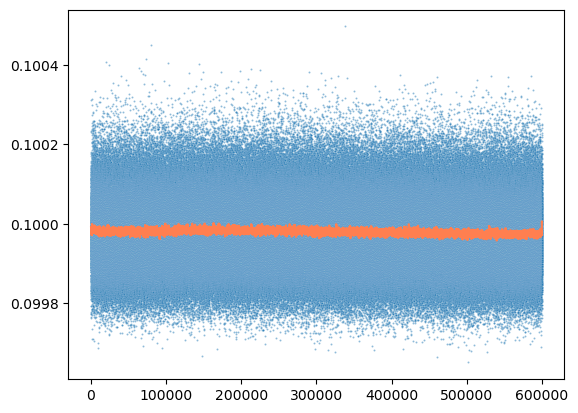

INFO     Generating sequential column names                                                                        


  0%|          | 0/18197 [00:00<?, ?it/s]

  0%|          | 40/18197 [00:00<00:45, 396.28it/s]

  0%|          | 81/18197 [00:00<00:45, 398.72it/s]

  1%|          | 122/18197 [00:00<00:45, 400.91it/s]

  1%|          | 163/18197 [00:00<00:44, 403.74it/s]

  1%|          | 204/18197 [00:00<00:44, 403.99it/s]

  1%|▏         | 245/18197 [00:00<00:44, 403.52it/s]

  2%|▏         | 286/18197 [00:00<00:44, 402.28it/s]

  2%|▏         | 327/18197 [00:00<00:44, 401.31it/s]

  2%|▏         | 368/18197 [00:00<00:44, 402.50it/s]

  2%|▏         | 409/18197 [00:01<00:44, 402.32it/s]

  2%|▏         | 450/18197 [00:01<00:44, 401.10it/s]

  3%|▎         | 491/18197 [00:01<00:44, 396.95it/s]

  3%|▎         | 533/18197 [00:01<00:43, 401.69it/s]

  3%|▎         | 574/18197 [00:01<00:43, 401.09it/s]

  3%|▎         | 615/18197 [00:01<00:43, 401.81it/s]

  4%|▎         | 656/18197 [00:01<00:43, 403.36it/s]

  4%|▍         | 697/18197 [00:01<00:43, 403.95it/s]

  4%|▍         | 738/18197 [00:01<00:43, 404.65it/s]

  4%|▍         | 779/18197 [00:01<00:43, 404.95it/s]

  5%|▍         | 821/18197 [00:02<00:42, 407.12it/s]

  5%|▍         | 862/18197 [00:02<00:42, 405.90it/s]

  5%|▍         | 903/18197 [00:02<00:42, 406.80it/s]

  5%|▌         | 944/18197 [00:02<00:42, 406.96it/s]

  5%|▌         | 986/18197 [00:02<00:42, 408.03it/s]

  6%|▌         | 1028/18197 [00:02<00:42, 408.76it/s]

  6%|▌         | 1070/18197 [00:02<00:41, 409.87it/s]

  6%|▌         | 1111/18197 [00:02<00:41, 409.33it/s]

  6%|▋         | 1152/18197 [00:02<00:41, 408.93it/s]

  7%|▋         | 1193/18197 [00:02<00:41, 407.18it/s]

  7%|▋         | 1234/18197 [00:03<00:41, 405.00it/s]

  7%|▋         | 1275/18197 [00:03<00:41, 406.40it/s]

  7%|▋         | 1316/18197 [00:03<00:41, 405.22it/s]

  7%|▋         | 1357/18197 [00:03<00:41, 406.53it/s]

  8%|▊         | 1398/18197 [00:03<00:41, 407.37it/s]

  8%|▊         | 1439/18197 [00:03<00:41, 404.43it/s]

  8%|▊         | 1480/18197 [00:03<00:41, 405.94it/s]

  8%|▊         | 1522/18197 [00:03<00:40, 408.55it/s]

  9%|▊         | 1563/18197 [00:03<00:40, 407.59it/s]

  9%|▉         | 1605/18197 [00:03<00:40, 408.56it/s]

  9%|▉         | 1646/18197 [00:04<00:40, 407.61it/s]

  9%|▉         | 1687/18197 [00:04<00:40, 407.75it/s]

 10%|▉         | 1729/18197 [00:04<00:40, 408.82it/s]

 10%|▉         | 1770/18197 [00:04<00:40, 408.53it/s]

 10%|▉         | 1811/18197 [00:04<00:40, 408.70it/s]

 10%|█         | 1853/18197 [00:04<00:39, 409.39it/s]

 10%|█         | 1895/18197 [00:04<00:39, 410.51it/s]

 11%|█         | 1937/18197 [00:04<00:39, 408.95it/s]

 11%|█         | 1979/18197 [00:04<00:39, 409.20it/s]

 11%|█         | 2020/18197 [00:04<00:39, 409.18it/s]

 11%|█▏        | 2062/18197 [00:05<00:39, 410.00it/s]

 12%|█▏        | 2104/18197 [00:05<00:39, 410.94it/s]

 12%|█▏        | 2146/18197 [00:05<00:39, 409.91it/s]

 12%|█▏        | 2187/18197 [00:05<00:39, 409.50it/s]

 12%|█▏        | 2228/18197 [00:05<00:39, 408.40it/s]

 12%|█▏        | 2269/18197 [00:05<00:38, 408.46it/s]

 13%|█▎        | 2311/18197 [00:05<00:38, 410.13it/s]

 13%|█▎        | 2353/18197 [00:05<00:38, 408.96it/s]

 13%|█▎        | 2394/18197 [00:05<00:38, 408.79it/s]

 13%|█▎        | 2435/18197 [00:05<00:38, 407.23it/s]

 14%|█▎        | 2477/18197 [00:06<00:38, 408.20it/s]

 14%|█▍        | 2518/18197 [00:06<00:38, 407.00it/s]

 14%|█▍        | 2560/18197 [00:06<00:38, 408.17it/s]

 14%|█▍        | 2601/18197 [00:06<00:38, 407.11it/s]

 15%|█▍        | 2643/18197 [00:06<00:38, 408.23it/s]

 15%|█▍        | 2684/18197 [00:06<00:38, 406.42it/s]

 15%|█▍        | 2726/18197 [00:06<00:37, 407.88it/s]

 15%|█▌        | 2767/18197 [00:06<00:37, 408.28it/s]

 15%|█▌        | 2809/18197 [00:06<00:37, 408.85it/s]

 16%|█▌        | 2851/18197 [00:07<00:37, 409.67it/s]

 16%|█▌        | 2892/18197 [00:07<00:37, 409.76it/s]

 16%|█▌        | 2933/18197 [00:07<00:37, 406.90it/s]

 16%|█▋        | 2975/18197 [00:07<00:37, 408.38it/s]

 17%|█▋        | 3016/18197 [00:07<00:37, 407.41it/s]

 17%|█▋        | 3057/18197 [00:07<00:37, 406.82it/s]

 17%|█▋        | 3099/18197 [00:07<00:36, 408.63it/s]

 17%|█▋        | 3140/18197 [00:07<00:36, 407.85it/s]

 17%|█▋        | 3181/18197 [00:07<00:36, 407.37it/s]

 18%|█▊        | 3222/18197 [00:07<00:36, 407.16it/s]

 18%|█▊        | 3264/18197 [00:08<00:36, 408.91it/s]

 18%|█▊        | 3305/18197 [00:08<00:36, 409.11it/s]

 18%|█▊        | 3347/18197 [00:08<00:36, 410.72it/s]

 19%|█▊        | 3389/18197 [00:08<00:36, 410.16it/s]

 19%|█▉        | 3431/18197 [00:08<00:36, 409.77it/s]

 19%|█▉        | 3472/18197 [00:08<00:35, 409.32it/s]

 19%|█▉        | 3514/18197 [00:08<00:35, 409.89it/s]

 20%|█▉        | 3555/18197 [00:08<00:35, 409.25it/s]

 20%|█▉        | 3596/18197 [00:08<00:35, 409.28it/s]

 20%|█▉        | 3638/18197 [00:08<00:35, 410.00it/s]

 20%|██        | 3679/18197 [00:09<00:35, 409.34it/s]

 20%|██        | 3721/18197 [00:09<00:35, 410.22it/s]

 21%|██        | 3763/18197 [00:09<00:35, 407.98it/s]

 21%|██        | 3804/18197 [00:09<00:35, 408.01it/s]

 21%|██        | 3846/18197 [00:09<00:35, 409.35it/s]

 21%|██▏       | 3887/18197 [00:09<00:35, 406.88it/s]

 22%|██▏       | 3928/18197 [00:09<00:35, 406.60it/s]

 22%|██▏       | 3969/18197 [00:09<00:35, 403.78it/s]

 22%|██▏       | 4010/18197 [00:09<00:35, 403.00it/s]

 22%|██▏       | 4051/18197 [00:09<00:35, 403.27it/s]

 22%|██▏       | 4092/18197 [00:10<00:35, 402.41it/s]

 23%|██▎       | 4133/18197 [00:10<00:34, 402.87it/s]

 23%|██▎       | 4174/18197 [00:10<00:34, 403.74it/s]

 23%|██▎       | 4215/18197 [00:10<00:34, 405.04it/s]

 23%|██▎       | 4256/18197 [00:10<00:34, 405.75it/s]

 24%|██▎       | 4297/18197 [00:10<00:34, 405.82it/s]

 24%|██▍       | 4339/18197 [00:10<00:33, 407.84it/s]

 24%|██▍       | 4380/18197 [00:10<00:33, 407.77it/s]

 24%|██▍       | 4421/18197 [00:10<00:33, 407.57it/s]

 25%|██▍       | 4462/18197 [00:10<00:33, 408.00it/s]

 25%|██▍       | 4503/18197 [00:11<00:33, 408.19it/s]

 25%|██▍       | 4545/18197 [00:11<00:33, 409.60it/s]

 25%|██▌       | 4586/18197 [00:11<00:33, 406.24it/s]

 25%|██▌       | 4627/18197 [00:11<00:33, 406.98it/s]

 26%|██▌       | 4669/18197 [00:11<00:33, 408.57it/s]

 26%|██▌       | 4711/18197 [00:11<00:32, 410.39it/s]

 26%|██▌       | 4753/18197 [00:11<00:32, 412.92it/s]

 26%|██▋       | 4795/18197 [00:11<00:32, 411.47it/s]

 27%|██▋       | 4837/18197 [00:11<00:32, 410.24it/s]

 27%|██▋       | 4879/18197 [00:11<00:32, 410.40it/s]

 27%|██▋       | 4921/18197 [00:12<00:32, 410.11it/s]

 27%|██▋       | 4963/18197 [00:12<00:32, 411.15it/s]

 28%|██▊       | 5005/18197 [00:12<00:32, 411.03it/s]

 28%|██▊       | 5047/18197 [00:12<00:32, 409.87it/s]

 28%|██▊       | 5089/18197 [00:12<00:31, 410.05it/s]

 28%|██▊       | 5131/18197 [00:12<00:31, 410.25it/s]

 28%|██▊       | 5173/18197 [00:12<00:31, 410.30it/s]

 29%|██▊       | 5215/18197 [00:12<00:31, 411.11it/s]

 29%|██▉       | 5257/18197 [00:12<00:31, 411.45it/s]

 29%|██▉       | 5299/18197 [00:13<00:31, 412.32it/s]

 29%|██▉       | 5341/18197 [00:13<00:31, 411.72it/s]

 30%|██▉       | 5383/18197 [00:13<00:30, 413.36it/s]

 30%|██▉       | 5425/18197 [00:13<00:30, 415.20it/s]

 30%|███       | 5467/18197 [00:13<00:30, 412.65it/s]

 30%|███       | 5509/18197 [00:13<00:30, 412.58it/s]

 31%|███       | 5551/18197 [00:13<00:30, 413.17it/s]

 31%|███       | 5593/18197 [00:13<00:30, 412.93it/s]

 31%|███       | 5635/18197 [00:13<00:30, 414.28it/s]

 31%|███       | 5677/18197 [00:13<00:30, 414.79it/s]

 31%|███▏      | 5719/18197 [00:14<00:30, 415.10it/s]

 32%|███▏      | 5761/18197 [00:14<00:29, 414.78it/s]

 32%|███▏      | 5803/18197 [00:14<00:29, 416.32it/s]

 32%|███▏      | 5845/18197 [00:14<00:29, 415.44it/s]

 32%|███▏      | 5887/18197 [00:14<00:29, 416.71it/s]

 33%|███▎      | 5929/18197 [00:14<00:29, 413.06it/s]

 33%|███▎      | 5971/18197 [00:14<00:29, 409.42it/s]

 33%|███▎      | 6012/18197 [00:14<00:29, 408.46it/s]

 33%|███▎      | 6054/18197 [00:14<00:29, 409.31it/s]

 33%|███▎      | 6095/18197 [00:14<00:29, 408.39it/s]

 34%|███▎      | 6136/18197 [00:15<00:29, 405.07it/s]

 34%|███▍      | 6177/18197 [00:15<00:29, 405.89it/s]

 34%|███▍      | 6218/18197 [00:15<00:29, 406.02it/s]

 34%|███▍      | 6259/18197 [00:15<00:29, 407.18it/s]

 35%|███▍      | 6301/18197 [00:15<00:29, 409.11it/s]

 35%|███▍      | 6343/18197 [00:15<00:28, 409.85it/s]

 35%|███▌      | 6385/18197 [00:15<00:28, 410.41it/s]

 35%|███▌      | 6427/18197 [00:15<00:28, 412.02it/s]

 36%|███▌      | 6469/18197 [00:15<00:28, 409.72it/s]

 36%|███▌      | 6511/18197 [00:15<00:28, 410.57it/s]

 36%|███▌      | 6553/18197 [00:16<00:28, 410.32it/s]

 36%|███▌      | 6595/18197 [00:16<00:28, 411.07it/s]

 36%|███▋      | 6637/18197 [00:16<00:28, 410.44it/s]

 37%|███▋      | 6679/18197 [00:16<00:27, 411.67it/s]

 37%|███▋      | 6721/18197 [00:16<00:27, 412.03it/s]

 37%|███▋      | 6763/18197 [00:16<00:27, 411.69it/s]

 37%|███▋      | 6805/18197 [00:16<00:27, 409.84it/s]

 38%|███▊      | 6847/18197 [00:16<00:27, 410.59it/s]

 38%|███▊      | 6889/18197 [00:16<00:27, 411.01it/s]

 38%|███▊      | 6931/18197 [00:16<00:27, 412.03it/s]

 38%|███▊      | 6973/18197 [00:17<00:27, 413.00it/s]

 39%|███▊      | 7015/18197 [00:17<00:27, 410.58it/s]

 39%|███▉      | 7057/18197 [00:17<00:27, 410.04it/s]

 39%|███▉      | 7099/18197 [00:17<00:27, 408.76it/s]

 39%|███▉      | 7140/18197 [00:17<00:27, 406.91it/s]

 39%|███▉      | 7181/18197 [00:17<00:27, 406.33it/s]

 40%|███▉      | 7222/18197 [00:17<00:27, 406.36it/s]

 40%|███▉      | 7263/18197 [00:17<00:26, 407.17it/s]

 40%|████      | 7304/18197 [00:17<00:26, 407.78it/s]

 40%|████      | 7345/18197 [00:17<00:26, 406.34it/s]

 41%|████      | 7386/18197 [00:18<00:26, 407.33it/s]

 41%|████      | 7427/18197 [00:18<00:26, 404.91it/s]

 41%|████      | 7468/18197 [00:18<00:26, 404.36it/s]

 41%|████▏     | 7509/18197 [00:18<00:26, 404.64it/s]

 41%|████▏     | 7551/18197 [00:18<00:26, 407.11it/s]

 42%|████▏     | 7592/18197 [00:18<00:26, 406.57it/s]

 42%|████▏     | 7633/18197 [00:18<00:26, 403.77it/s]

 42%|████▏     | 7674/18197 [00:18<00:26, 404.06it/s]

 42%|████▏     | 7715/18197 [00:18<00:25, 405.47it/s]

 43%|████▎     | 7757/18197 [00:19<00:25, 407.78it/s]

 43%|████▎     | 7798/18197 [00:19<00:25, 406.90it/s]

 43%|████▎     | 7839/18197 [00:19<00:25, 405.10it/s]

 43%|████▎     | 7880/18197 [00:19<00:25, 406.52it/s]

 44%|████▎     | 7921/18197 [00:19<00:25, 406.86it/s]

 44%|████▍     | 7962/18197 [00:19<00:25, 405.43it/s]

 44%|████▍     | 8004/18197 [00:19<00:24, 407.75it/s]

 44%|████▍     | 8046/18197 [00:19<00:24, 410.42it/s]

 44%|████▍     | 8088/18197 [00:19<00:24, 410.16it/s]

 45%|████▍     | 8130/18197 [00:19<00:24, 412.12it/s]

 45%|████▍     | 8172/18197 [00:20<00:24, 409.67it/s]

 45%|████▌     | 8213/18197 [00:20<00:24, 409.29it/s]

 45%|████▌     | 8255/18197 [00:20<00:24, 409.92it/s]

 46%|████▌     | 8297/18197 [00:20<00:24, 410.70it/s]

 46%|████▌     | 8339/18197 [00:20<00:23, 412.45it/s]

 46%|████▌     | 8381/18197 [00:20<00:23, 409.14it/s]

 46%|████▋     | 8422/18197 [00:20<00:23, 407.66it/s]

 47%|████▋     | 8463/18197 [00:20<00:23, 407.70it/s]

 47%|████▋     | 8505/18197 [00:20<00:23, 408.93it/s]

 47%|████▋     | 8546/18197 [00:20<00:23, 406.78it/s]

 47%|████▋     | 8587/18197 [00:21<00:23, 406.43it/s]

 47%|████▋     | 8628/18197 [00:21<00:23, 405.94it/s]

 48%|████▊     | 8670/18197 [00:21<00:23, 407.93it/s]

 48%|████▊     | 8711/18197 [00:21<00:23, 406.20it/s]

 48%|████▊     | 8752/18197 [00:21<00:23, 406.65it/s]

 48%|████▊     | 8794/18197 [00:21<00:23, 407.92it/s]

 49%|████▊     | 8836/18197 [00:21<00:22, 408.84it/s]

 49%|████▉     | 8877/18197 [00:21<00:22, 408.40it/s]

 49%|████▉     | 8918/18197 [00:21<00:22, 406.49it/s]

 49%|████▉     | 8959/18197 [00:21<00:22, 405.98it/s]

 49%|████▉     | 9000/18197 [00:22<00:22, 405.95it/s]

 50%|████▉     | 9041/18197 [00:22<00:22, 405.98it/s]

 50%|████▉     | 9082/18197 [00:22<00:22, 406.98it/s]

 50%|█████     | 9124/18197 [00:22<00:22, 408.77it/s]

 50%|█████     | 9166/18197 [00:22<00:22, 409.98it/s]

 51%|█████     | 9208/18197 [00:22<00:21, 410.40it/s]

 51%|█████     | 9250/18197 [00:22<00:21, 410.42it/s]

 51%|█████     | 9292/18197 [00:22<00:21, 409.95it/s]

 51%|█████▏    | 9334/18197 [00:22<00:21, 410.79it/s]

 52%|█████▏    | 9376/18197 [00:22<00:21, 409.90it/s]

 52%|█████▏    | 9418/18197 [00:23<00:21, 412.07it/s]

 52%|█████▏    | 9460/18197 [00:23<00:21, 410.92it/s]

 52%|█████▏    | 9502/18197 [00:23<00:21, 409.84it/s]

 52%|█████▏    | 9544/18197 [00:23<00:21, 410.18it/s]

 53%|█████▎    | 9586/18197 [00:23<00:20, 411.50it/s]

 53%|█████▎    | 9628/18197 [00:23<00:20, 412.79it/s]

 53%|█████▎    | 9670/18197 [00:23<00:20, 413.55it/s]

 53%|█████▎    | 9712/18197 [00:23<00:20, 414.57it/s]

 54%|█████▎    | 9754/18197 [00:23<00:20, 413.71it/s]

 54%|█████▍    | 9796/18197 [00:23<00:20, 412.27it/s]

 54%|█████▍    | 9838/18197 [00:24<00:20, 412.49it/s]

 54%|█████▍    | 9880/18197 [00:24<00:20, 412.05it/s]

 55%|█████▍    | 9922/18197 [00:24<00:20, 412.88it/s]

 55%|█████▍    | 9964/18197 [00:24<00:19, 413.92it/s]

 55%|█████▍    | 10006/18197 [00:24<00:19, 414.62it/s]

 55%|█████▌    | 10048/18197 [00:24<00:19, 414.70it/s]

 55%|█████▌    | 10090/18197 [00:24<00:19, 413.51it/s]

 56%|█████▌    | 10132/18197 [00:24<00:19, 413.93it/s]

 56%|█████▌    | 10174/18197 [00:24<00:19, 412.61it/s]

 56%|█████▌    | 10216/18197 [00:25<00:19, 411.32it/s]

 56%|█████▋    | 10258/18197 [00:25<00:19, 410.92it/s]

 57%|█████▋    | 10300/18197 [00:25<00:19, 410.52it/s]

 57%|█████▋    | 10342/18197 [00:25<00:19, 410.93it/s]

 57%|█████▋    | 10384/18197 [00:25<00:19, 408.51it/s]

 57%|█████▋    | 10426/18197 [00:25<00:18, 409.41it/s]

 58%|█████▊    | 10467/18197 [00:25<00:18, 408.51it/s]

 58%|█████▊    | 10508/18197 [00:25<00:18, 408.89it/s]

 58%|█████▊    | 10550/18197 [00:25<00:18, 409.61it/s]

 58%|█████▊    | 10592/18197 [00:25<00:18, 409.82it/s]

 58%|█████▊    | 10634/18197 [00:26<00:18, 409.98it/s]

 59%|█████▊    | 10675/18197 [00:26<00:18, 409.97it/s]

 59%|█████▉    | 10717/18197 [00:26<00:18, 411.28it/s]

 59%|█████▉    | 10759/18197 [00:26<00:18, 411.65it/s]

 59%|█████▉    | 10801/18197 [00:26<00:17, 413.20it/s]

 60%|█████▉    | 10843/18197 [00:26<00:17, 414.47it/s]

 60%|█████▉    | 10885/18197 [00:26<00:17, 415.53it/s]

 60%|██████    | 10927/18197 [00:26<00:17, 414.34it/s]

 60%|██████    | 10969/18197 [00:26<00:17, 414.51it/s]

 61%|██████    | 11011/18197 [00:26<00:17, 412.06it/s]

 61%|██████    | 11053/18197 [00:27<00:17, 412.16it/s]

 61%|██████    | 11095/18197 [00:27<00:17, 412.59it/s]

 61%|██████    | 11137/18197 [00:27<00:17, 413.26it/s]

 61%|██████▏   | 11179/18197 [00:27<00:16, 414.79it/s]

 62%|██████▏   | 11221/18197 [00:27<00:16, 414.50it/s]

 62%|██████▏   | 11263/18197 [00:27<00:16, 415.87it/s]

 62%|██████▏   | 11305/18197 [00:27<00:16, 415.96it/s]

 62%|██████▏   | 11348/18197 [00:27<00:16, 417.23it/s]

 63%|██████▎   | 11391/18197 [00:27<00:16, 418.10it/s]

 63%|██████▎   | 11433/18197 [00:27<00:16, 413.07it/s]

 63%|██████▎   | 11475/18197 [00:28<00:16, 409.95it/s]

 63%|██████▎   | 11517/18197 [00:28<00:16, 408.47it/s]

 64%|██████▎   | 11559/18197 [00:28<00:16, 409.23it/s]

 64%|██████▍   | 11601/18197 [00:28<00:16, 410.05it/s]

 64%|██████▍   | 11643/18197 [00:28<00:15, 410.90it/s]

 64%|██████▍   | 11685/18197 [00:28<00:15, 411.81it/s]

 64%|██████▍   | 11727/18197 [00:28<00:15, 412.70it/s]

 65%|██████▍   | 11769/18197 [00:28<00:15, 413.75it/s]

 65%|██████▍   | 11811/18197 [00:28<00:15, 413.37it/s]

 65%|██████▌   | 11853/18197 [00:28<00:15, 412.78it/s]

 65%|██████▌   | 11895/18197 [00:29<00:15, 414.34it/s]

 66%|██████▌   | 11937/18197 [00:29<00:15, 413.76it/s]

 66%|██████▌   | 11979/18197 [00:29<00:15, 411.86it/s]

 66%|██████▌   | 12021/18197 [00:29<00:14, 412.50it/s]

 66%|██████▋   | 12063/18197 [00:29<00:14, 413.25it/s]

 67%|██████▋   | 12105/18197 [00:29<00:14, 413.60it/s]

 67%|██████▋   | 12147/18197 [00:29<00:14, 414.55it/s]

 67%|██████▋   | 12189/18197 [00:29<00:14, 411.47it/s]

 67%|██████▋   | 12231/18197 [00:29<00:14, 411.82it/s]

 67%|██████▋   | 12273/18197 [00:29<00:14, 412.04it/s]

 68%|██████▊   | 12315/18197 [00:30<00:14, 412.82it/s]

 68%|██████▊   | 12357/18197 [00:30<00:14, 413.68it/s]

 68%|██████▊   | 12399/18197 [00:30<00:14, 412.87it/s]

 68%|██████▊   | 12441/18197 [00:30<00:13, 414.14it/s]

 69%|██████▊   | 12483/18197 [00:30<00:13, 415.43it/s]

 69%|██████▉   | 12525/18197 [00:30<00:13, 414.66it/s]

 69%|██████▉   | 12567/18197 [00:30<00:13, 414.48it/s]

 69%|██████▉   | 12609/18197 [00:30<00:13, 414.33it/s]

 70%|██████▉   | 12651/18197 [00:30<00:13, 414.58it/s]

 70%|██████▉   | 12693/18197 [00:31<00:13, 415.26it/s]

 70%|██████▉   | 12735/18197 [00:31<00:13, 414.20it/s]

 70%|███████   | 12777/18197 [00:31<00:13, 415.44it/s]

 70%|███████   | 12819/18197 [00:31<00:12, 414.36it/s]

 71%|███████   | 12861/18197 [00:31<00:12, 415.62it/s]

 71%|███████   | 12903/18197 [00:31<00:12, 416.30it/s]

 71%|███████   | 12945/18197 [00:31<00:12, 414.20it/s]

 71%|███████▏  | 12987/18197 [00:31<00:12, 413.45it/s]

 72%|███████▏  | 13029/18197 [00:31<00:12, 414.03it/s]

 72%|███████▏  | 13071/18197 [00:31<00:12, 414.18it/s]

 72%|███████▏  | 13113/18197 [00:32<00:12, 414.92it/s]

 72%|███████▏  | 13155/18197 [00:32<00:12, 413.99it/s]

 73%|███████▎  | 13197/18197 [00:32<00:12, 413.40it/s]

 73%|███████▎  | 13239/18197 [00:32<00:11, 414.17it/s]

 73%|███████▎  | 13281/18197 [00:32<00:11, 413.92it/s]

 73%|███████▎  | 13323/18197 [00:32<00:11, 414.62it/s]

 73%|███████▎  | 13365/18197 [00:32<00:11, 415.24it/s]

 74%|███████▎  | 13407/18197 [00:32<00:11, 412.95it/s]

 74%|███████▍  | 13449/18197 [00:32<00:11, 412.83it/s]

 74%|███████▍  | 13491/18197 [00:32<00:11, 409.33it/s]

 74%|███████▍  | 13532/18197 [00:33<00:11, 408.27it/s]

 75%|███████▍  | 13574/18197 [00:33<00:11, 409.78it/s]

 75%|███████▍  | 13616/18197 [00:33<00:11, 411.76it/s]

 75%|███████▌  | 13658/18197 [00:33<00:11, 409.02it/s]

 75%|███████▌  | 13699/18197 [00:33<00:10, 409.10it/s]

 76%|███████▌  | 13741/18197 [00:33<00:10, 409.57it/s]

 76%|███████▌  | 13783/18197 [00:33<00:10, 410.94it/s]

 76%|███████▌  | 13825/18197 [00:33<00:10, 408.88it/s]

 76%|███████▌  | 13866/18197 [00:33<00:10, 409.09it/s]

 76%|███████▋  | 13907/18197 [00:33<00:10, 409.04it/s]

 77%|███████▋  | 13948/18197 [00:34<00:10, 409.05it/s]

 77%|███████▋  | 13990/18197 [00:34<00:10, 409.93it/s]

 77%|███████▋  | 14032/18197 [00:34<00:10, 411.71it/s]

 77%|███████▋  | 14074/18197 [00:34<00:10, 411.57it/s]

 78%|███████▊  | 14116/18197 [00:34<00:09, 409.58it/s]

 78%|███████▊  | 14158/18197 [00:34<00:09, 410.71it/s]

 78%|███████▊  | 14200/18197 [00:34<00:09, 411.94it/s]

 78%|███████▊  | 14242/18197 [00:34<00:09, 412.99it/s]

 78%|███████▊  | 14284/18197 [00:34<00:09, 414.05it/s]

 79%|███████▊  | 14326/18197 [00:34<00:09, 412.69it/s]

 79%|███████▉  | 14368/18197 [00:35<00:09, 413.32it/s]

 79%|███████▉  | 14410/18197 [00:35<00:09, 413.74it/s]

 79%|███████▉  | 14452/18197 [00:35<00:09, 414.43it/s]

 80%|███████▉  | 14494/18197 [00:35<00:08, 415.19it/s]

 80%|███████▉  | 14536/18197 [00:35<00:08, 416.10it/s]

 80%|████████  | 14578/18197 [00:35<00:08, 416.08it/s]

 80%|████████  | 14620/18197 [00:35<00:08, 414.12it/s]

 81%|████████  | 14662/18197 [00:35<00:08, 414.88it/s]

 81%|████████  | 14704/18197 [00:35<00:08, 415.27it/s]

 81%|████████  | 14746/18197 [00:35<00:08, 413.96it/s]

 81%|████████▏ | 14788/18197 [00:36<00:08, 413.88it/s]

 81%|████████▏ | 14830/18197 [00:36<00:08, 414.39it/s]

 82%|████████▏ | 14872/18197 [00:36<00:08, 413.75it/s]

 82%|████████▏ | 14914/18197 [00:36<00:07, 412.47it/s]

 82%|████████▏ | 14956/18197 [00:36<00:07, 412.16it/s]

 82%|████████▏ | 14998/18197 [00:36<00:07, 411.65it/s]

 83%|████████▎ | 15040/18197 [00:36<00:07, 412.02it/s]

 83%|████████▎ | 15082/18197 [00:36<00:07, 412.63it/s]

 83%|████████▎ | 15124/18197 [00:36<00:07, 413.35it/s]

 83%|████████▎ | 15166/18197 [00:36<00:07, 414.33it/s]

 84%|████████▎ | 15208/18197 [00:37<00:07, 409.36it/s]

 84%|████████▍ | 15249/18197 [00:37<00:07, 408.72it/s]

 84%|████████▍ | 15291/18197 [00:37<00:07, 409.27it/s]

 84%|████████▍ | 15333/18197 [00:37<00:06, 409.85it/s]

 84%|████████▍ | 15375/18197 [00:37<00:06, 411.25it/s]

 85%|████████▍ | 15417/18197 [00:37<00:06, 405.67it/s]

 85%|████████▍ | 15458/18197 [00:37<00:06, 404.52it/s]

 85%|████████▌ | 15499/18197 [00:37<00:06, 405.16it/s]

 85%|████████▌ | 15540/18197 [00:37<00:06, 404.43it/s]

 86%|████████▌ | 15581/18197 [00:38<00:06, 404.56it/s]

 86%|████████▌ | 15622/18197 [00:38<00:06, 403.52it/s]

 86%|████████▌ | 15663/18197 [00:38<00:06, 402.92it/s]

 86%|████████▋ | 15704/18197 [00:38<00:06, 403.61it/s]

 87%|████████▋ | 15746/18197 [00:38<00:06, 405.43it/s]

 87%|████████▋ | 15787/18197 [00:38<00:05, 402.40it/s]

 87%|████████▋ | 15828/18197 [00:38<00:05, 402.67it/s]

 87%|████████▋ | 15869/18197 [00:38<00:05, 404.10it/s]

 87%|████████▋ | 15911/18197 [00:38<00:05, 406.12it/s]

 88%|████████▊ | 15952/18197 [00:38<00:05, 405.80it/s]

 88%|████████▊ | 15993/18197 [00:39<00:05, 405.79it/s]

 88%|████████▊ | 16034/18197 [00:39<00:05, 406.42it/s]

 88%|████████▊ | 16076/18197 [00:39<00:05, 407.57it/s]

 89%|████████▊ | 16117/18197 [00:39<00:05, 403.81it/s]

 89%|████████▉ | 16158/18197 [00:39<00:05, 401.24it/s]

 89%|████████▉ | 16199/18197 [00:39<00:04, 400.90it/s]

 89%|████████▉ | 16240/18197 [00:39<00:04, 401.97it/s]

 89%|████████▉ | 16281/18197 [00:39<00:04, 402.72it/s]

 90%|████████▉ | 16322/18197 [00:39<00:04, 400.56it/s]

 90%|████████▉ | 16363/18197 [00:39<00:04, 399.36it/s]

 90%|█████████ | 16404/18197 [00:40<00:04, 400.65it/s]

 90%|█████████ | 16445/18197 [00:40<00:04, 400.86it/s]

 91%|█████████ | 16486/18197 [00:40<00:04, 403.10it/s]

 91%|█████████ | 16528/18197 [00:40<00:04, 407.50it/s]

 91%|█████████ | 16570/18197 [00:40<00:03, 409.50it/s]

 91%|█████████▏| 16611/18197 [00:40<00:03, 409.06it/s]

 92%|█████████▏| 16652/18197 [00:40<00:03, 409.07it/s]

 92%|█████████▏| 16693/18197 [00:40<00:03, 409.13it/s]

 92%|█████████▏| 16734/18197 [00:40<00:03, 409.36it/s]

 92%|█████████▏| 16775/18197 [00:40<00:03, 409.14it/s]

 92%|█████████▏| 16816/18197 [00:41<00:03, 409.23it/s]

 93%|█████████▎| 16858/18197 [00:41<00:03, 409.65it/s]

 93%|█████████▎| 16899/18197 [00:41<00:03, 409.64it/s]

 93%|█████████▎| 16941/18197 [00:41<00:03, 410.19it/s]

 93%|█████████▎| 16983/18197 [00:41<00:02, 410.72it/s]

 94%|█████████▎| 17025/18197 [00:41<00:02, 410.78it/s]

 94%|█████████▍| 17067/18197 [00:41<00:02, 409.11it/s]

 94%|█████████▍| 17108/18197 [00:41<00:02, 409.10it/s]

 94%|█████████▍| 17150/18197 [00:41<00:02, 410.74it/s]

 94%|█████████▍| 17192/18197 [00:41<00:02, 410.16it/s]

 95%|█████████▍| 17234/18197 [00:42<00:02, 410.43it/s]

 95%|█████████▍| 17276/18197 [00:42<00:02, 410.71it/s]

 95%|█████████▌| 17318/18197 [00:42<00:02, 411.24it/s]

 95%|█████████▌| 17360/18197 [00:42<00:02, 410.95it/s]

 96%|█████████▌| 17402/18197 [00:42<00:01, 409.22it/s]

 96%|█████████▌| 17443/18197 [00:42<00:01, 408.65it/s]

 96%|█████████▌| 17484/18197 [00:42<00:01, 407.60it/s]

 96%|█████████▋| 17526/18197 [00:42<00:01, 408.56it/s]

 97%|█████████▋| 17568/18197 [00:42<00:01, 409.89it/s]

 97%|█████████▋| 17610/18197 [00:43<00:01, 410.46it/s]

 97%|█████████▋| 17652/18197 [00:43<00:01, 410.66it/s]

 97%|█████████▋| 17694/18197 [00:43<00:01, 410.22it/s]

 97%|█████████▋| 17736/18197 [00:43<00:01, 410.80it/s]

 98%|█████████▊| 17778/18197 [00:43<00:01, 409.79it/s]

 98%|█████████▊| 17819/18197 [00:43<00:00, 408.26it/s]

 98%|█████████▊| 17860/18197 [00:43<00:00, 405.68it/s]

 98%|█████████▊| 17901/18197 [00:43<00:00, 405.20it/s]

 99%|█████████▊| 17942/18197 [00:43<00:00, 405.44it/s]

 99%|█████████▉| 17983/18197 [00:43<00:00, 405.84it/s]

 99%|█████████▉| 18024/18197 [00:44<00:00, 405.76it/s]

 99%|█████████▉| 18065/18197 [00:44<00:00, 406.69it/s]

 99%|█████████▉| 18106/18197 [00:44<00:00, 406.10it/s]

100%|█████████▉| 18147/18197 [00:44<00:00, 406.57it/s]

100%|█████████▉| 18188/18197 [00:44<00:00, 407.39it/s]

100%|██████████| 18197/18197 [00:44<00:00, 409.43it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

  5%|▍         | 14/285 [00:00<00:02, 132.29it/s]

 10%|▉         | 28/285 [00:00<00:01, 131.28it/s]

 15%|█▍        | 42/285 [00:00<00:01, 130.94it/s]

 20%|█▉        | 56/285 [00:00<00:01, 130.71it/s]

 25%|██▍       | 70/285 [00:00<00:01, 130.56it/s]

 29%|██▉       | 84/285 [00:00<00:01, 130.31it/s]

 34%|███▍      | 98/285 [00:00<00:01, 130.26it/s]

 39%|███▉      | 112/285 [00:00<00:01, 130.17it/s]

 44%|████▍     | 126/285 [00:00<00:01, 130.24it/s]

 49%|████▉     | 140/285 [00:01<00:01, 130.03it/s]

 54%|█████▍    | 154/285 [00:01<00:01, 129.93it/s]

 59%|█████▊    | 167/285 [00:01<00:00, 129.94it/s]

 64%|██████▎   | 181/285 [00:01<00:00, 130.05it/s]

 68%|██████▊   | 195/285 [00:01<00:00, 130.14it/s]

 73%|███████▎  | 209/285 [00:01<00:00, 130.09it/s]

 78%|███████▊  | 223/285 [00:01<00:00, 130.11it/s]

 83%|████████▎ | 237/285 [00:01<00:00, 130.09it/s]

 88%|████████▊ | 251/285 [00:01<00:00, 130.06it/s]

 93%|█████████▎| 265/285 [00:02<00:00, 129.91it/s]

 98%|█████████▊| 278/285 [00:02<00:00, 129.81it/s]

100%|██████████| 285/285 [00:02<00:00, 130.42it/s]

IORegistryError: No method registered for writing <class 'bytes'> into <class 'h5py._hl.group.Group'>

In [11]:
antipode_model.run_standard_protocol(out_path,
                                     max_steps=max_steps,
                                     num_particles=num_particles,
                                     device=device,
                                     max_learning_rate=1e-3,
                                     one_cycle_lr=True,
                                     batch_size=batch_size,
                                     correction_steps=None)

In [12]:
# To redo correction
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')

In [13]:
# antipode_model=ANTIPODE.load(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),adata=adata,prefix='p3_',device=device)
# adata=antipode_model.adata_manager.adata
# antipode_model.store_outputs(device=device,prefix='')

In [14]:
# antipode_model.to(device)
# posterior_out,posterior_categories = antipode_model.correct_fits(batch_size=128, n_steps = 100000)
# antipode_model.store_outputs(device=device,prefix='')


In [15]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Sat Mar  8 12:54:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:61:00.0 Off |                    0 |
| N/A   48C    P0             60W /  300W |     930MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Sat Mar  8 12:54:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:61:00.0 Off |                    0 |
| N/A   48C    P0             61W /  300W |     930MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 45,min_dist=0.2,spread=1,metric='manhattan')
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

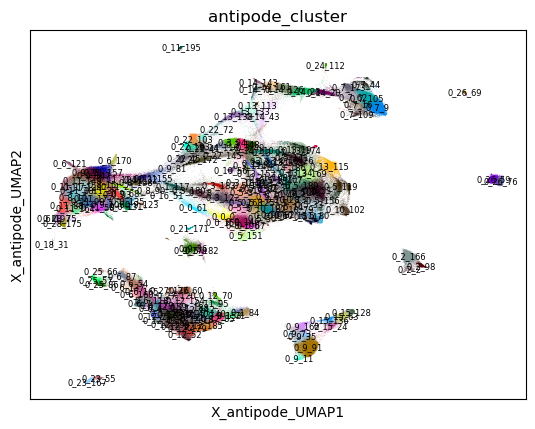

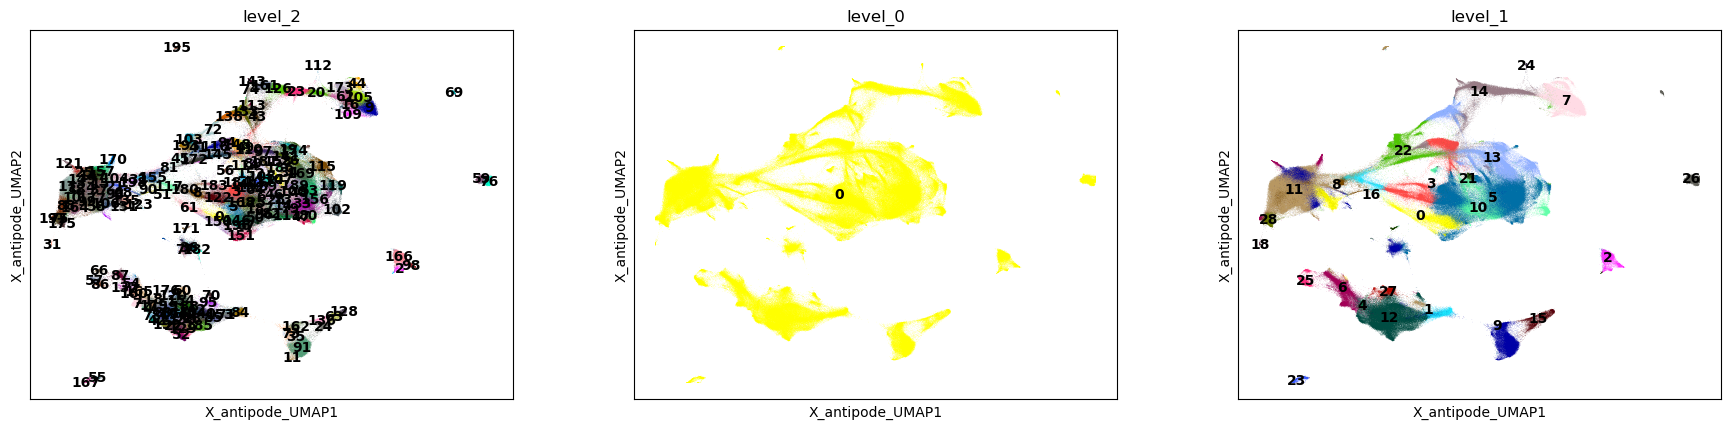

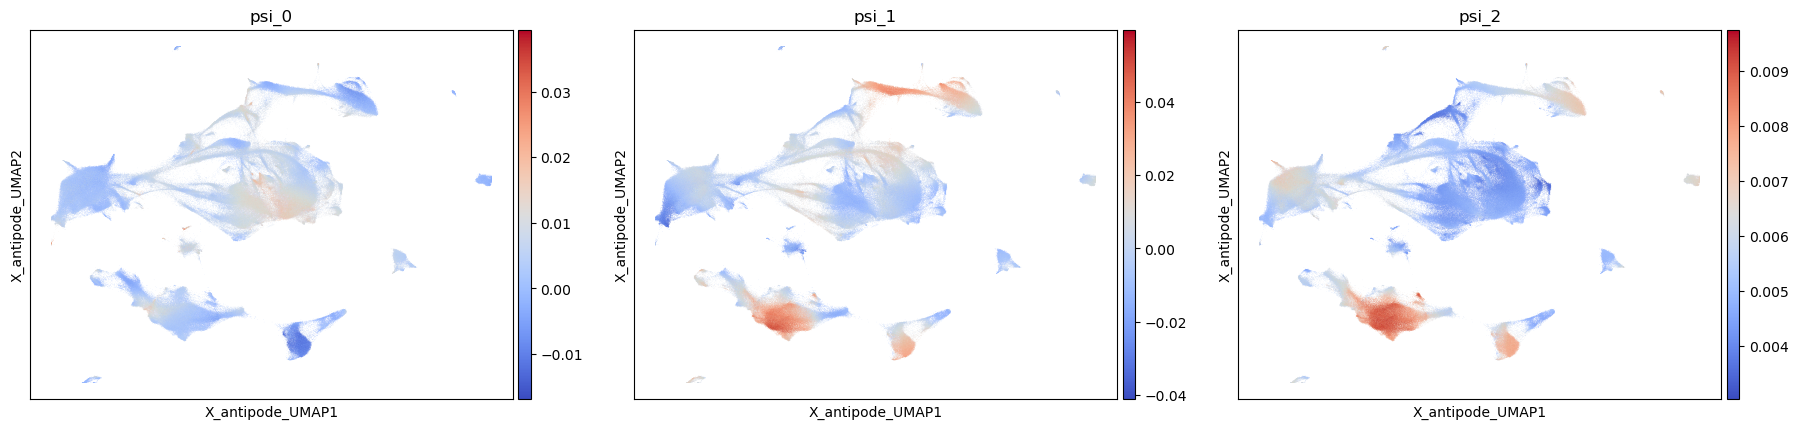

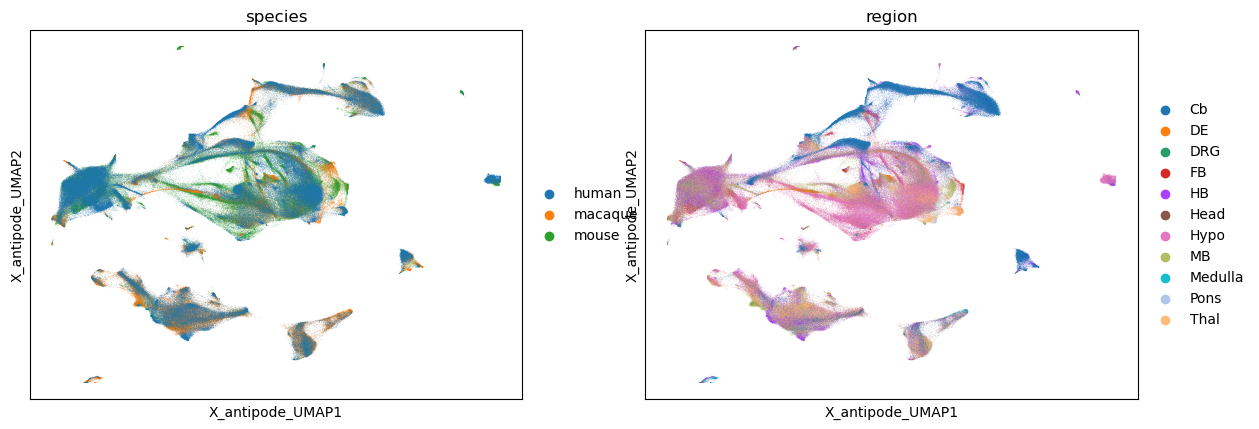

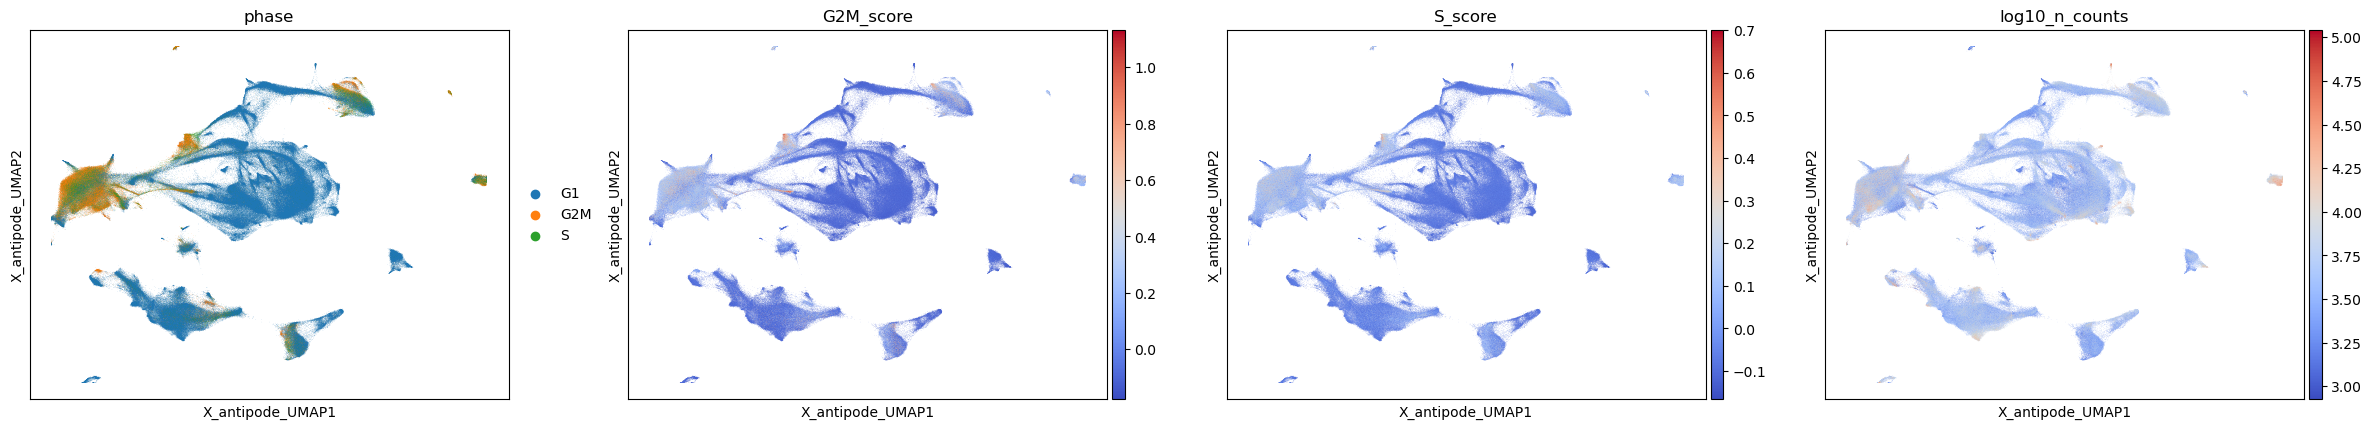

In [17]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species','region']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)


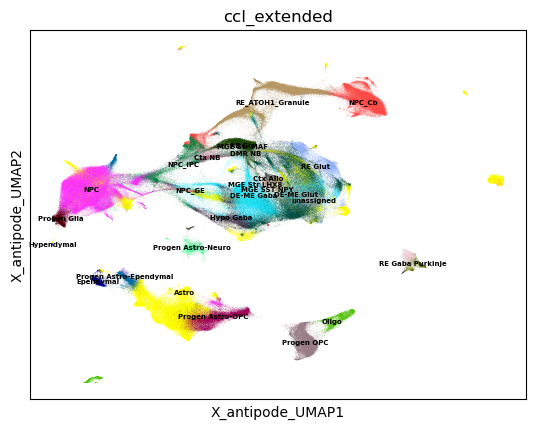

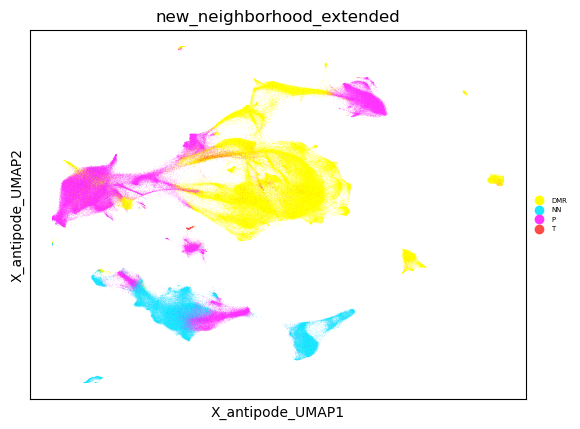

In [18]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102,legend_fontsize=5,
    color=['ccl_extended']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    palette=sc.pl.palettes.godsnot_102,legend_fontsize=5,
    color=['new_neighborhood_extended']
)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


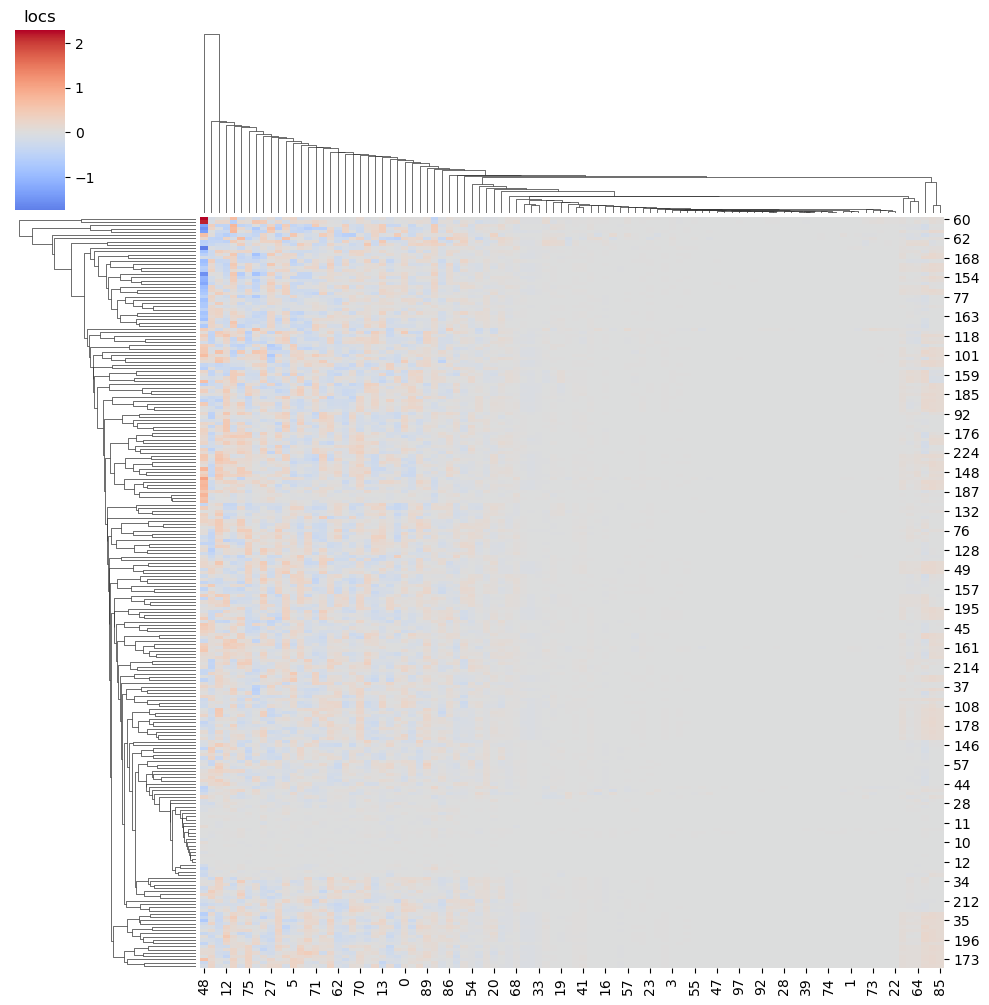

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


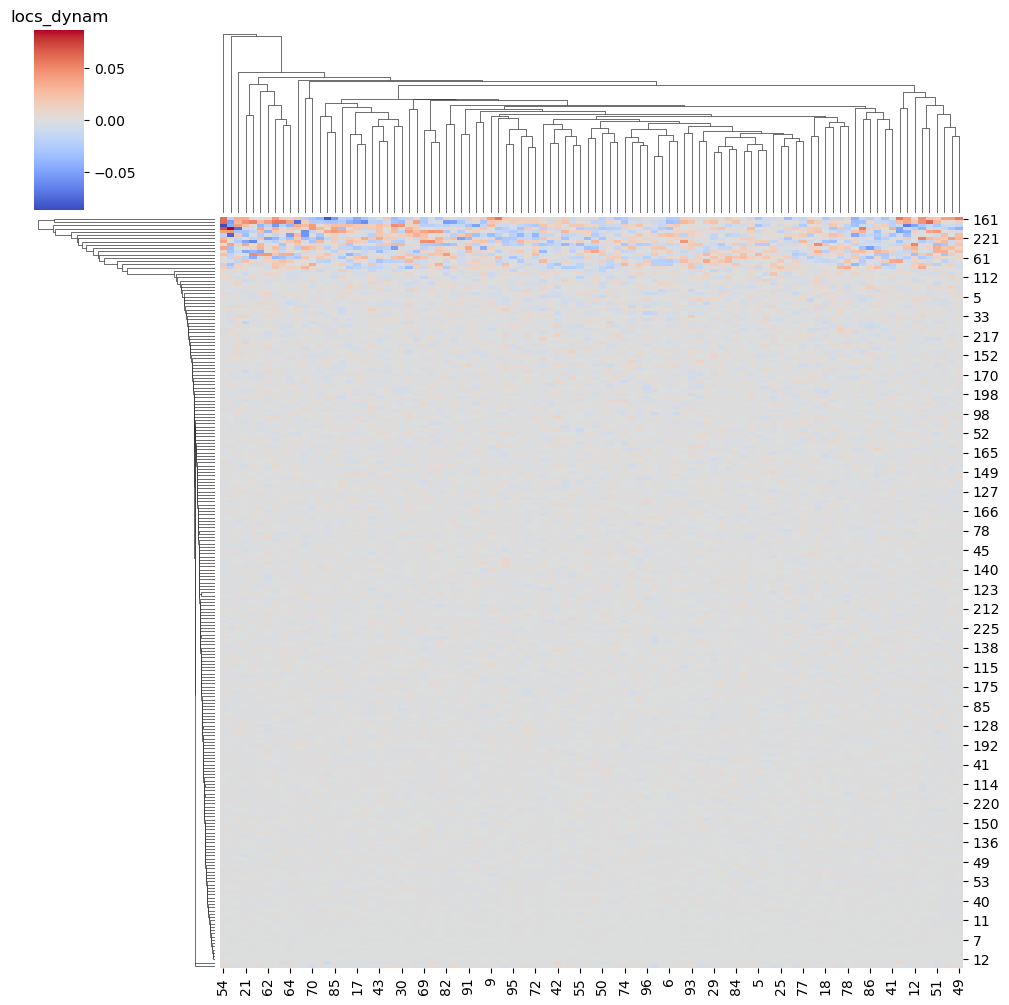

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


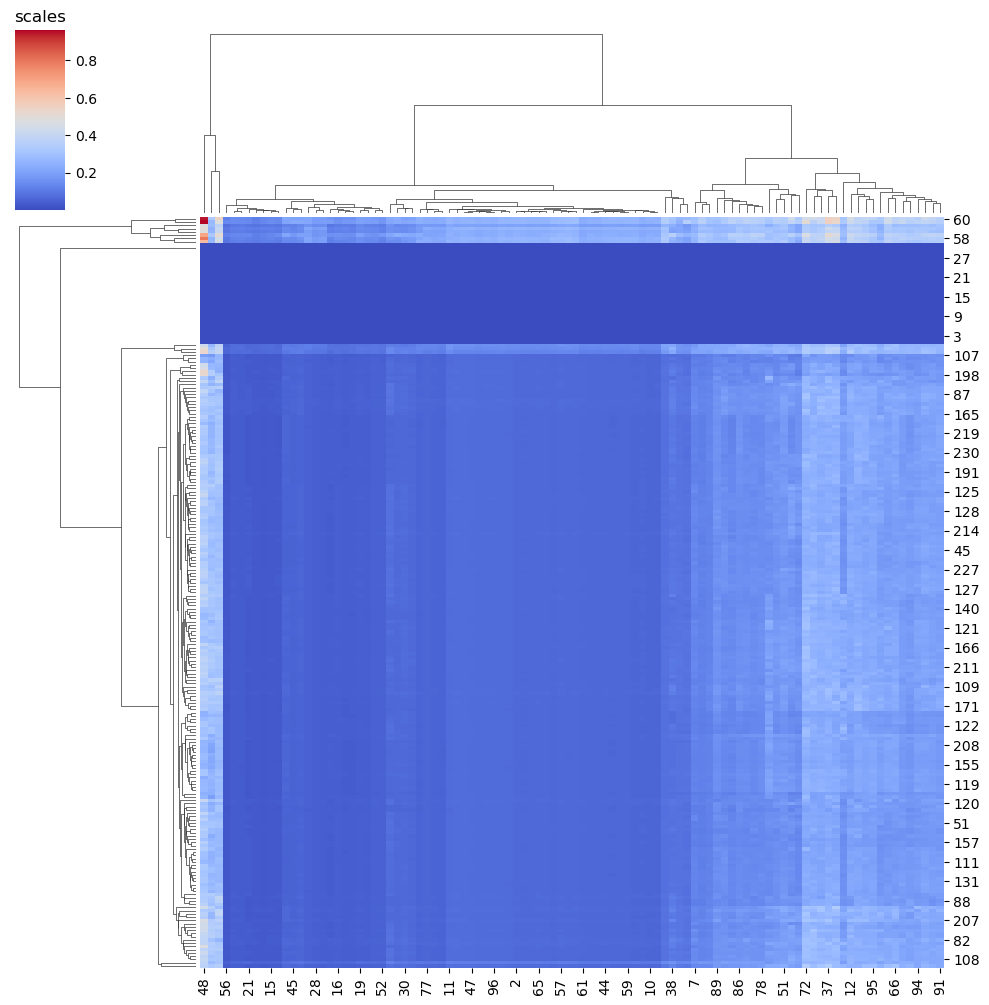

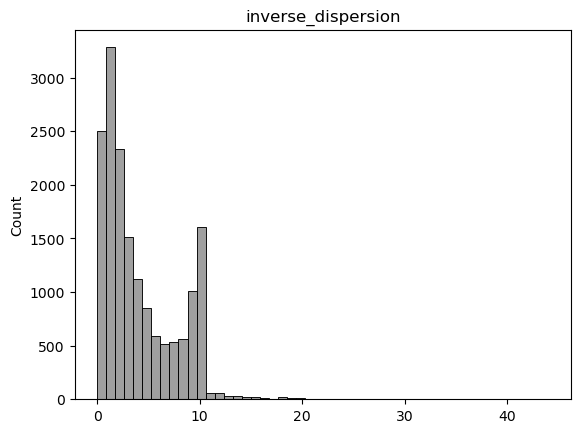

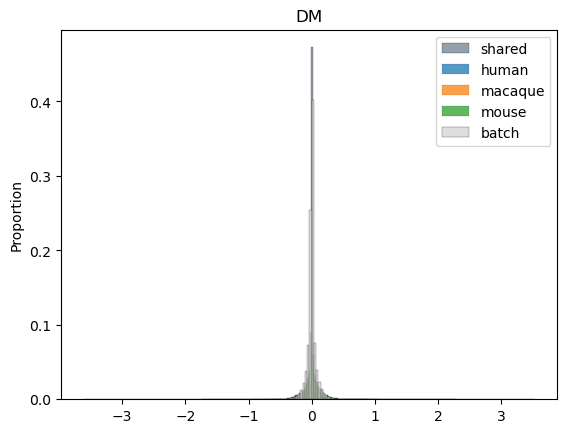

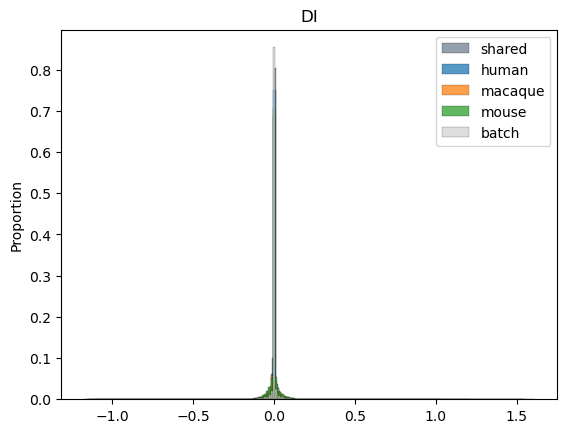

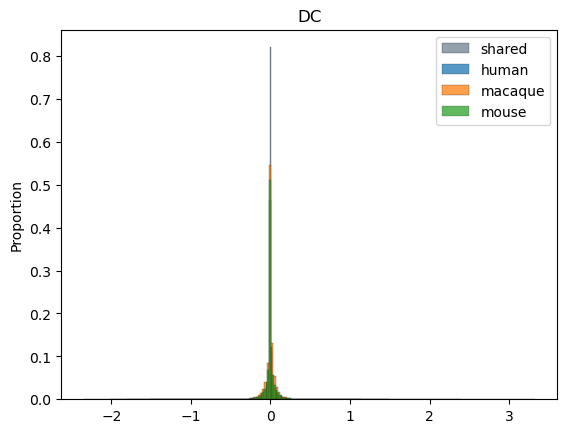

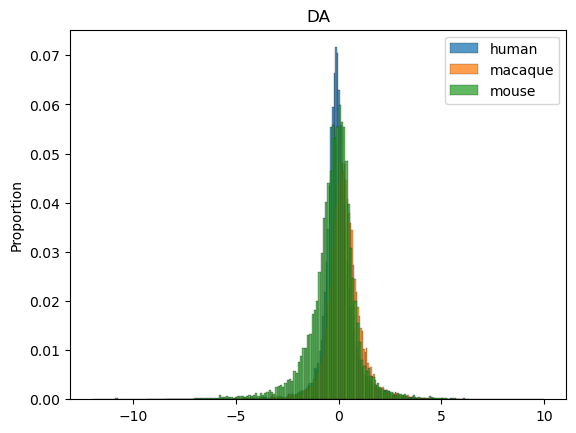

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(antipode_model.batch_key)[color_key]


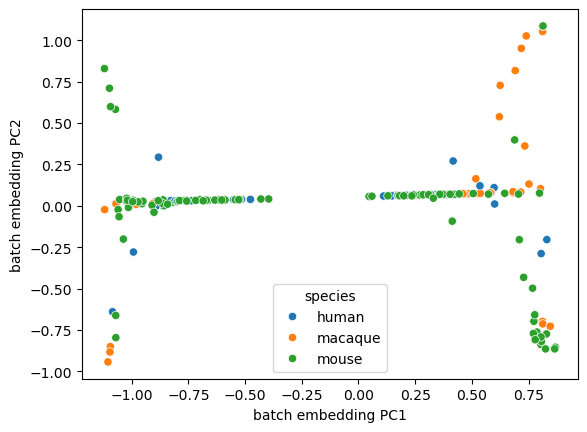

,0,1,batch_name,species
0,-0.737800,0.029781,CS12OpticVesicle_kOut,human
1,0.280190,0.065010,CS13_anterior_midbrain_kOut,human
2,-0.550042,0.036916,CS13_central_midbrain_kOut,human
3,-0.515867,0.038233,CS13_hindbrain_kOut,human
4,-0.828427,0.030396,CS13_olfactory_pacode_kOut,human
...,...,...,...,...
214,-0.684503,0.029912,e18.0_ForebrainVentroThalamic_SRR11947679,mouse
215,-1.018383,0.033624,e18.0_Hindbrain_SRR11947663,mouse
216,-0.995452,0.024345,e18.0_Hindbrain_SRR11947680,mouse
217,0.779060,-0.809057,e18.0_Midbrain_SRR11947633,mouse


In [19]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [20]:
pstore=adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:]
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:445: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:446: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


ValueError: too many values to unpack (expected 5)

In [21]:
leaf_key = 'level_2'
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]

  0%|          | 0/567 [00:00<?, ?it/s]

  1%|          | 4/567 [00:00<00:36, 15.25it/s]

  1%|          | 7/567 [00:00<00:28, 19.53it/s]

  2%|▏         | 10/567 [00:00<00:33, 16.41it/s]

  2%|▏         | 14/567 [00:00<00:26, 20.84it/s]

  3%|▎         | 17/567 [00:01<00:34, 15.97it/s]

  3%|▎         | 19/567 [00:01<00:35, 15.37it/s]

  4%|▎         | 21/567 [00:01<00:35, 15.28it/s]

  4%|▍         | 23/567 [00:01<00:37, 14.50it/s]

  5%|▍         | 26/567 [00:01<00:33, 16.25it/s]

  5%|▌         | 30/567 [00:01<00:34, 15.48it/s]

  6%|▌         | 33/567 [00:02<00:33, 15.94it/s]

  6%|▌         | 35/567 [00:02<00:44, 11.91it/s]

  7%|▋         | 38/567 [00:02<00:36, 14.53it/s]

  7%|▋         | 41/567 [00:02<00:31, 16.69it/s]

  8%|▊         | 43/567 [00:02<00:30, 17.23it/s]

  8%|▊         | 45/567 [00:02<00:34, 15.27it/s]

  8%|▊         | 47/567 [00:03<00:35, 14.45it/s]

  9%|▊         | 49/567 [00:03<00:33, 15.44it/s]

  9%|▉         | 51/567 [00:03<00:52,  9.86it/s]

 10%|▉         | 55/567 [00:03<00:39, 12.95it/s]

 10%|█         | 57/567 [00:03<00:40, 12.67it/s]

 10%|█         | 59/567 [00:04<00:38, 13.35it/s]

 11%|█         | 62/567 [00:04<00:32, 15.74it/s]

 12%|█▏        | 68/567 [00:04<00:21, 23.19it/s]

 13%|█▎        | 71/567 [00:04<00:21, 23.08it/s]

 13%|█▎        | 74/567 [00:04<00:22, 22.01it/s]

 14%|█▍        | 79/567 [00:04<00:17, 28.21it/s]

 15%|█▍        | 83/567 [00:04<00:18, 26.26it/s]

 15%|█▌        | 86/567 [00:05<00:22, 21.53it/s]

 16%|█▌        | 89/567 [00:05<00:25, 18.68it/s]

 16%|█▌        | 92/567 [00:05<00:27, 17.40it/s]

 17%|█▋        | 95/567 [00:05<00:24, 19.55it/s]

 17%|█▋        | 98/567 [00:05<00:35, 13.27it/s]

 18%|█▊        | 100/567 [00:06<00:36, 12.82it/s]

 18%|█▊        | 102/567 [00:06<00:41, 11.27it/s]

 19%|█▊        | 106/567 [00:06<00:29, 15.81it/s]

 20%|█▉        | 111/567 [00:06<00:20, 21.97it/s]

 20%|██        | 116/567 [00:06<00:16, 27.06it/s]

 21%|██        | 120/567 [00:07<00:23, 19.18it/s]

 22%|██▏       | 123/567 [00:07<00:26, 17.01it/s]

 22%|██▏       | 126/567 [00:07<00:23, 18.44it/s]

 23%|██▎       | 130/567 [00:07<00:19, 21.92it/s]

 23%|██▎       | 133/567 [00:07<00:21, 20.35it/s]

 24%|██▍       | 136/567 [00:07<00:20, 21.43it/s]

 25%|██▍       | 140/567 [00:07<00:18, 23.07it/s]

 25%|██▌       | 143/567 [00:08<00:28, 15.12it/s]

 26%|██▌       | 145/567 [00:08<00:29, 14.21it/s]

 26%|██▋       | 149/567 [00:08<00:22, 18.35it/s]

 27%|██▋       | 152/567 [00:08<00:25, 16.37it/s]

 27%|██▋       | 155/567 [00:09<00:25, 16.42it/s]

 28%|██▊       | 157/567 [00:09<00:25, 16.29it/s]

 28%|██▊       | 159/567 [00:09<00:24, 16.65it/s]

 28%|██▊       | 161/567 [00:09<00:27, 15.01it/s]

 29%|██▊       | 163/567 [00:09<00:30, 13.10it/s]

 29%|██▉       | 166/567 [00:09<00:25, 15.80it/s]

 30%|██▉       | 168/567 [00:09<00:24, 16.06it/s]

 30%|███       | 172/567 [00:10<00:18, 21.18it/s]

 31%|███▏      | 178/567 [00:10<00:14, 26.45it/s]

 32%|███▏      | 181/567 [00:10<00:16, 22.89it/s]

 32%|███▏      | 184/567 [00:10<00:15, 24.17it/s]

 34%|███▎      | 190/567 [00:10<00:11, 31.88it/s]

 34%|███▍      | 194/567 [00:10<00:11, 32.33it/s]

 35%|███▍      | 198/567 [00:10<00:12, 28.92it/s]

 36%|███▌      | 202/567 [00:11<00:14, 26.04it/s]

 37%|███▋      | 207/567 [00:11<00:12, 28.00it/s]

 37%|███▋      | 211/567 [00:11<00:15, 23.30it/s]

 38%|███▊      | 214/567 [00:11<00:15, 22.55it/s]

 39%|███▊      | 219/567 [00:11<00:13, 25.37it/s]

 39%|███▉      | 222/567 [00:11<00:14, 24.04it/s]

 40%|████      | 229/567 [00:12<00:10, 31.86it/s]

 41%|████▏     | 234/567 [00:12<00:09, 34.88it/s]

 42%|████▏     | 238/567 [00:12<00:10, 32.00it/s]

 43%|████▎     | 242/567 [00:12<00:11, 29.21it/s]

 43%|████▎     | 246/567 [00:12<00:11, 29.07it/s]

 44%|████▍     | 250/567 [00:12<00:11, 27.34it/s]

 45%|████▍     | 253/567 [00:13<00:13, 22.48it/s]

 46%|████▌     | 258/567 [00:13<00:11, 27.76it/s]

 46%|████▌     | 262/567 [00:13<00:11, 27.71it/s]

 47%|████▋     | 267/567 [00:13<00:09, 32.67it/s]

 48%|████▊     | 271/567 [00:13<00:10, 28.09it/s]

 49%|████▊     | 275/567 [00:13<00:10, 28.23it/s]

 49%|████▉     | 279/567 [00:14<00:15, 18.09it/s]

 50%|████▉     | 283/567 [00:14<00:13, 20.71it/s]

 51%|█████     | 287/567 [00:14<00:11, 23.34it/s]

 51%|█████     | 290/567 [00:14<00:13, 21.25it/s]

 52%|█████▏    | 296/567 [00:14<00:09, 28.45it/s]

 53%|█████▎    | 300/567 [00:14<00:09, 29.09it/s]

 54%|█████▍    | 306/567 [00:14<00:07, 34.96it/s]

 55%|█████▍    | 310/567 [00:15<00:07, 34.62it/s]

 55%|█████▌    | 314/567 [00:15<00:09, 26.91it/s]

 56%|█████▌    | 318/567 [00:15<00:09, 26.61it/s]

 57%|█████▋    | 322/567 [00:15<00:08, 29.12it/s]

 58%|█████▊    | 327/567 [00:15<00:07, 33.04it/s]

 59%|█████▊    | 332/567 [00:15<00:06, 33.58it/s]

 60%|█████▉    | 339/567 [00:15<00:05, 41.23it/s]

 61%|██████    | 344/567 [00:16<00:05, 37.90it/s]

 62%|██████▏   | 349/567 [00:16<00:07, 27.83it/s]

 62%|██████▏   | 353/567 [00:16<00:07, 27.79it/s]

 63%|██████▎   | 357/567 [00:16<00:07, 29.31it/s]

 64%|██████▍   | 363/567 [00:16<00:05, 35.57it/s]

 65%|██████▍   | 367/567 [00:16<00:06, 32.75it/s]

 65%|██████▌   | 371/567 [00:17<00:06, 29.48it/s]

 66%|██████▋   | 376/567 [00:17<00:05, 32.73it/s]

 67%|██████▋   | 380/567 [00:17<00:06, 27.71it/s]

 68%|██████▊   | 384/567 [00:17<00:09, 19.71it/s]

 68%|██████▊   | 387/567 [00:17<00:09, 19.52it/s]

 69%|██████▉   | 391/567 [00:17<00:07, 22.01it/s]

 69%|██████▉   | 394/567 [00:18<00:07, 23.01it/s]

 70%|███████   | 397/567 [00:18<00:07, 21.79it/s]

 71%|███████   | 403/567 [00:18<00:06, 27.28it/s]

 72%|███████▏  | 406/567 [00:18<00:06, 25.70it/s]

 72%|███████▏  | 409/567 [00:18<00:08, 17.85it/s]

 73%|███████▎  | 412/567 [00:19<00:09, 17.00it/s]

 73%|███████▎  | 414/567 [00:19<00:09, 16.84it/s]

 74%|███████▎  | 418/567 [00:19<00:07, 21.17it/s]

 75%|███████▍  | 423/567 [00:19<00:06, 21.87it/s]

 75%|███████▌  | 426/567 [00:19<00:06, 21.25it/s]

 76%|███████▌  | 429/567 [00:19<00:06, 20.18it/s]

 77%|███████▋  | 434/567 [00:19<00:05, 24.28it/s]

 77%|███████▋  | 438/567 [00:20<00:04, 27.28it/s]

 78%|███████▊  | 442/567 [00:20<00:04, 29.80it/s]

 79%|███████▉  | 447/567 [00:20<00:03, 32.80it/s]

 80%|███████▉  | 451/567 [00:20<00:03, 32.36it/s]

 80%|████████  | 455/567 [00:20<00:03, 33.17it/s]

 81%|████████▏ | 461/567 [00:20<00:02, 39.56it/s]

 82%|████████▏ | 466/567 [00:20<00:02, 36.21it/s]

 83%|████████▎ | 470/567 [00:20<00:02, 34.13it/s]

 84%|████████▎ | 474/567 [00:21<00:03, 24.99it/s]

 84%|████████▍ | 477/567 [00:21<00:04, 22.05it/s]

 85%|████████▍ | 480/567 [00:21<00:03, 22.38it/s]

 85%|████████▌ | 483/567 [00:21<00:04, 20.39it/s]

 86%|████████▌ | 486/567 [00:21<00:04, 18.41it/s]

 86%|████████▌ | 489/567 [00:22<00:03, 20.44it/s]

 87%|████████▋ | 492/567 [00:22<00:03, 20.59it/s]

 87%|████████▋ | 495/567 [00:22<00:03, 20.47it/s]

 88%|████████▊ | 498/567 [00:22<00:03, 18.44it/s]

 88%|████████▊ | 500/567 [00:22<00:04, 15.22it/s]

 89%|████████▉ | 505/567 [00:22<00:02, 20.77it/s]

 90%|████████▉ | 508/567 [00:23<00:03, 18.97it/s]

 91%|█████████ | 517/567 [00:23<00:01, 28.93it/s]

 92%|█████████▏| 521/567 [00:23<00:02, 21.32it/s]

 92%|█████████▏| 524/567 [00:23<00:02, 18.24it/s]

 93%|█████████▎| 529/567 [00:23<00:01, 21.48it/s]

 94%|█████████▍| 532/567 [00:24<00:01, 20.41it/s]

 95%|█████████▍| 536/567 [00:24<00:01, 21.72it/s]

 95%|█████████▌| 540/567 [00:24<00:01, 21.77it/s]

 96%|█████████▌| 543/567 [00:24<00:01, 19.80it/s]

 96%|█████████▋| 546/567 [00:24<00:01, 18.46it/s]

 97%|█████████▋| 551/567 [00:25<00:00, 20.89it/s]

 98%|█████████▊| 554/567 [00:25<00:00, 19.64it/s]

 98%|█████████▊| 558/567 [00:25<00:00, 20.11it/s]

 99%|█████████▉| 561/567 [00:25<00:00, 21.45it/s]

 99%|█████████▉| 564/567 [00:25<00:00, 22.53it/s]

100%|██████████| 567/567 [00:25<00:00, 22.06it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  1%|          | 2/189 [00:00<00:10, 17.96it/s]

  2%|▏         | 4/189 [00:00<00:20,  9.00it/s]

  3%|▎         | 6/189 [00:00<00:17, 10.53it/s]

  4%|▍         | 8/189 [00:00<00:15, 11.92it/s]

  5%|▌         | 10/189 [00:01<00:20,  8.93it/s]

  7%|▋         | 13/189 [00:01<00:14, 12.47it/s]

  8%|▊         | 15/189 [00:01<00:13, 13.35it/s]

  9%|▉         | 17/189 [00:01<00:14, 11.83it/s]

 10%|█         | 19/189 [00:01<00:15, 10.97it/s]

 11%|█         | 21/189 [00:01<00:14, 11.43it/s]

 12%|█▏        | 23/189 [00:02<00:16,  9.82it/s]

 13%|█▎        | 25/189 [00:02<00:14, 11.49it/s]

 14%|█▍        | 27/189 [00:02<00:13, 11.73it/s]

 16%|█▌        | 30/189 [00:02<00:16,  9.51it/s]

 17%|█▋        | 32/189 [00:02<00:14, 10.73it/s]

 18%|█▊        | 34/189 [00:03<00:16,  9.44it/s]

 19%|█▉        | 36/189 [00:03<00:16,  9.41it/s]

 20%|██        | 38/189 [00:03<00:13, 11.07it/s]

 21%|██        | 40/189 [00:03<00:12, 11.96it/s]

 22%|██▏       | 42/189 [00:03<00:10, 13.40it/s]

 23%|██▎       | 44/189 [00:03<00:10, 14.25it/s]

 24%|██▍       | 46/189 [00:04<00:13, 10.97it/s]

 25%|██▌       | 48/189 [00:04<00:11, 11.85it/s]

 26%|██▋       | 50/189 [00:04<00:16,  8.57it/s]

 28%|██▊       | 52/189 [00:04<00:14,  9.65it/s]

 29%|██▉       | 55/189 [00:05<00:11, 11.32it/s]

 30%|███       | 57/189 [00:05<00:11, 11.13it/s]

 31%|███       | 59/189 [00:05<00:11, 11.28it/s]

 32%|███▏      | 61/189 [00:05<00:10, 12.31it/s]

 33%|███▎      | 63/189 [00:05<00:10, 11.82it/s]

 35%|███▍      | 66/189 [00:05<00:08, 15.34it/s]

 36%|███▌      | 68/189 [00:05<00:07, 16.02it/s]

 37%|███▋      | 70/189 [00:06<00:07, 15.51it/s]

 38%|███▊      | 72/189 [00:06<00:07, 15.79it/s]

 39%|███▉      | 74/189 [00:06<00:07, 15.42it/s]

 41%|████      | 77/189 [00:06<00:06, 17.64it/s]

 42%|████▏     | 80/189 [00:06<00:05, 20.09it/s]

 44%|████▍     | 83/189 [00:06<00:06, 17.07it/s]

 45%|████▍     | 85/189 [00:06<00:07, 14.34it/s]

 47%|████▋     | 88/189 [00:07<00:09, 10.89it/s]

 48%|████▊     | 90/189 [00:07<00:09, 10.92it/s]

 49%|████▊     | 92/189 [00:07<00:08, 11.60it/s]

 50%|████▉     | 94/189 [00:07<00:08, 11.84it/s]

 51%|█████     | 96/189 [00:08<00:08, 10.93it/s]

 52%|█████▏    | 98/189 [00:08<00:09,  9.13it/s]

 53%|█████▎    | 100/189 [00:08<00:09,  9.48it/s]

 54%|█████▍    | 102/189 [00:08<00:10,  8.68it/s]

 55%|█████▌    | 104/189 [00:08<00:08, 10.28it/s]

 56%|█████▌    | 106/189 [00:09<00:07, 10.83it/s]

 57%|█████▋    | 108/189 [00:09<00:06, 12.08it/s]

 59%|█████▊    | 111/189 [00:09<00:05, 13.75it/s]

 60%|█████▉    | 113/189 [00:09<00:05, 14.18it/s]

 61%|██████    | 115/189 [00:09<00:05, 14.16it/s]

 62%|██████▏   | 118/189 [00:09<00:04, 14.30it/s]

 63%|██████▎   | 120/189 [00:10<00:05, 12.76it/s]

 65%|██████▍   | 122/189 [00:10<00:06,  9.72it/s]

 66%|██████▌   | 125/189 [00:10<00:05, 11.25it/s]

 67%|██████▋   | 127/189 [00:10<00:04, 12.61it/s]

 68%|██████▊   | 129/189 [00:10<00:05, 11.64it/s]

 70%|██████▉   | 132/189 [00:11<00:03, 14.85it/s]

 71%|███████   | 134/189 [00:11<00:03, 14.72it/s]

 72%|███████▏  | 136/189 [00:11<00:03, 15.29it/s]

 74%|███████▎  | 139/189 [00:11<00:02, 17.34it/s]

 75%|███████▍  | 141/189 [00:11<00:03, 13.58it/s]

 76%|███████▌  | 143/189 [00:11<00:04, 10.41it/s]

 77%|███████▋  | 145/189 [00:12<00:04,  9.99it/s]

 79%|███████▉  | 149/189 [00:12<00:02, 13.55it/s]

 80%|███████▉  | 151/189 [00:12<00:02, 13.58it/s]

 81%|████████  | 153/189 [00:12<00:03, 11.65it/s]

 82%|████████▏ | 155/189 [00:12<00:02, 12.09it/s]

 83%|████████▎ | 157/189 [00:13<00:02, 11.51it/s]

 84%|████████▍ | 159/189 [00:13<00:02, 11.09it/s]

 85%|████████▌ | 161/189 [00:13<00:02, 10.63it/s]

 86%|████████▌ | 163/189 [00:13<00:02,  8.78it/s]

 88%|████████▊ | 166/189 [00:14<00:02, 10.38it/s]

 89%|████████▉ | 168/189 [00:14<00:01, 10.53it/s]

 90%|█████████ | 171/189 [00:14<00:01, 13.04it/s]

 92%|█████████▏| 173/189 [00:14<00:01, 14.02it/s]

 93%|█████████▎| 175/189 [00:14<00:00, 14.97it/s]

 94%|█████████▍| 178/189 [00:14<00:00, 14.88it/s]

 95%|█████████▌| 180/189 [00:14<00:00, 13.33it/s]

 96%|█████████▋| 182/189 [00:15<00:00, 12.40it/s]

 97%|█████████▋| 184/189 [00:15<00:00, 13.44it/s]

 99%|█████████▉| 187/189 [00:15<00:00, 16.30it/s]

100%|██████████| 189/189 [00:15<00:00, 16.08it/s]

100%|██████████| 189/189 [00:15<00:00, 12.17it/s]

In [22]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


NameError: name 'discov_cluster_params' is not defined

nan


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, '')

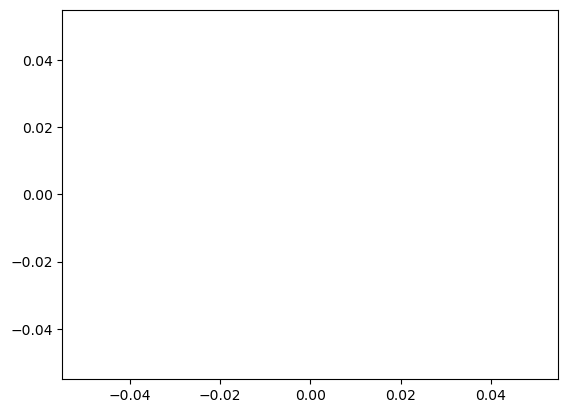

In [23]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

In [24]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

NameError: name 'discov_cluster_params' is not defined

In [25]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
# zeros=y>-20
# x=x[zeros]
# y=y[zeros]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

NameError: name 'discov_cluster_params' is not defined

In [26]:
antipode_model.save(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),save_anndata=True,prefix='p4_')

IORegistryError: No method registered for writing <class 'bytes'> into <class 'h5py._hl.group.Group'>